In [1]:
import os
import numpy as np
import cv2
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

Original Image


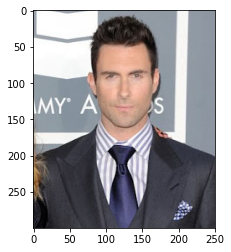

In [2]:
imgPath = "/Volumes/GoogleDrive/My Drive/Columbia/1.Courses/2021_Fall/STAT5293/HW/HW1/sl4500_LIM_HW1/"
imgFilename = "face_d2.jpeg"

img_filename = os.path.join(imgPath, imgFilename)
img_org = cv2.imread(img_filename)
img_RGB = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

print("Original Image")
plt.imshow(img_RGB);

k-value:  3


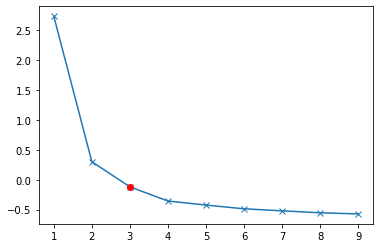

In [3]:
img_lab = cv2.cvtColor(img_org, cv2.COLOR_BGR2LAB)
img_ab_arr = img_lab[:,:,1:]
img_ab_arr_2d = img_ab_arr.reshape((-1,2))

# find the normalized sse
def find_sse(img_ab_arr_2d, k=10):
    sse = []
    for i in range(1,k):
        sse.append(KMeans(n_clusters=i).fit(img_ab_arr_2d).inertia_)
    sse = (sse - np.mean(sse)) / np.std(sse)
    return sse

sse = find_sse(img_ab_arr_2d)

# find the best number of clusters
def find_cluster_num(sse, k=10):
    for i in range(0,k-1):
        if sse[i] - sse[i+1] < 0.1:
            k = i
            break
    return k

k = find_cluster_num(sse)

# plot the graph
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(range(1,10), sse, marker = 'x');
ax.plot(k, sse[k-1], marker = 'o', color= 'red');
print("k-value: ", k)

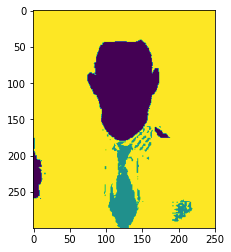

In [4]:
# segmented image
def kmeans_cluster(img_ab_arr_2d, img_org, k):
    km = KMeans(n_clusters=k, init='random')
    c = km.fit_predict(img_ab_arr_2d)
    segmented = c.reshape((img_org.shape[0], img_org.shape[1]))
    return km, segmented

km, segmented = kmeans_cluster(img_ab_arr_2d, img_org, k)

plt.imshow(segmented)

In [5]:
# check if there's right number of clusters
assert k == len(np.unique(segmented))

In [6]:
# OpenCV documentation RGB -> LAB equation
# a = a + 128, b = b + 128
# skin color around [22,22] -> [150, 150]
skin_color_lab = [142,143]

# decide which cluster centroid is closest to the skin color
from math import sqrt
def distance_2d(p1,p2):
    distance = sqrt( (p2[0]- p1[0])**2 + (p2[1] - p1[1])**2 ) 
    return distance 

def skin_cluster_num(km, k):
    dist = float("inf")
    cluster_num = 0
    for i in range(0,k):
        new_dist = distance_2d(km.cluster_centers_[i], skin_color_lab)

        if new_dist < dist:
            dist = new_dist
            cluster_num = i
    print("Cluster:", cluster_num, "\ndistance:", round(dist,2))
    return cluster_num

cluster_num = skin_cluster_num(km, k) 

Cluster: 0 
distance: 2.24


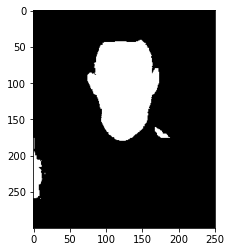

In [7]:
def binary_img(segmented, cluster_num):
    img_binary = np.zeros((segmented.shape[0], segmented.shape[1]))

    for i in range(segmented.shape[0]):
        for j in range(segmented.shape[1]):
            if segmented[i][j] != cluster_num:
                img_binary[i][j] = 0
            else:
                img_binary[i][j] = 1
    return img_binary

img_binary = binary_img(segmented, cluster_num)

plt.imshow(img_binary, cmap = 'gray')

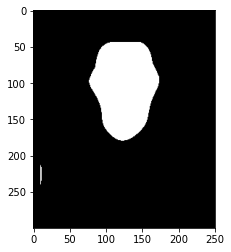

In [8]:
# median filtering to remove noise
def median_filter_cleaning(img_binary, size=10):
    clean_bin_img = np.zeros((img_binary.shape[0], img_binary.shape[1]))

    for i in range(size, img_binary.shape[0]-size):
        for j in range(size, img_binary.shape[1]-size):
            window = img_binary[i-size:i+size, j-size:j+size]
            window_1d = window.reshape(-1)
            median = statistics.median(window_1d)
            clean_bin_img[i][j] = median
    return clean_bin_img

clean_bin_img = median_filter_cleaning(img_binary)
        
plt.imshow(clean_bin_img, cmap = 'gray')

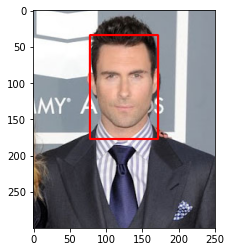

In [9]:
# draw a rectangle aroud the face
def draw_rect(img_org, clean_bin_img):
    width = []
    height = []

    for i in range(0,clean_bin_img.shape[0]):
        for j in range(0,clean_bin_img.shape[1]):
            if clean_bin_img[i][j] == 1:
                height.append(i)
                width.append(j)

    mean_width = np.mean(width)
    mean_height = np.mean(height)

    std_width = np.std(width)
    std_height = np.std(height)
    color = (255,0,0) # red in BGR
    thickness = 2

    img_RGB = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
    start_pt = (int(mean_width - 2 *std_width), int(mean_height + 2*std_height))
    end_pt = (int(mean_width + 2*std_width), int(mean_height - 2*std_height))
    rect = cv2.rectangle(img_RGB, start_pt, end_pt, color, thickness)

    plt.imshow(rect)

draw_rect(img_org, clean_bin_img)

# Extra Credit

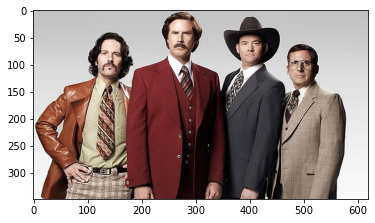

In [10]:
img = cv2.imread("/Volumes/GoogleDrive/My Drive/Columbia/1.Courses/2021_Fall/STAT5293/HW/HW1/sl4500_LIM_HW1/faces.jpeg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

In [11]:
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_ab_arr = img_lab[:,:,1:]
img_ab_arr_2d = img_ab_arr.reshape((-1,2))

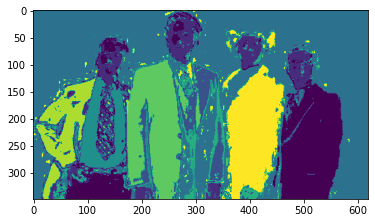

In [12]:
k=9
# segmented image
km, segmented = kmeans_cluster(img_ab_arr_2d, img, k)
plt.imshow(segmented)

Cluster: 1 
distance: 0.86


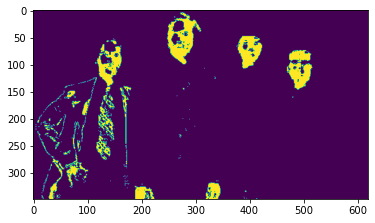

In [13]:
# decide which cluster centroid is closest to the skin color
cluster_num = skin_cluster_num(km, k)

img_binary = binary_img(segmented, cluster_num)
plt.imshow(img_binary)

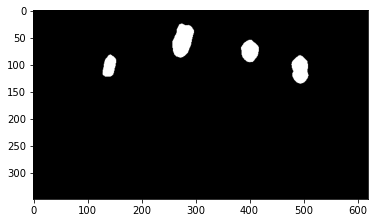

In [14]:
# median filtering to remove noise
clean_bin_img = median_filter_cleaning(img_binary, 20)
plt.imshow(clean_bin_img, cmap = 'gray')

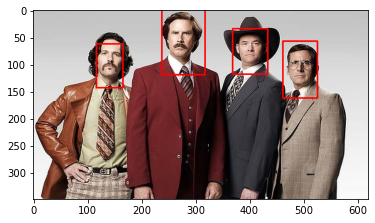

In [15]:
# draw rectangles around faces
# drawing rectangle referenced from https://stackoverflow.com/questions/63923800/drawing-bounding-rectangles-around-multiple-objects-in-binary-image-in-python
result = img_RGB.copy()
clean_bin_img = clean_bin_img.astype(np.uint8) #findcontours doesn't work with float32, so convert to unit8
contours = cv2.findContours(clean_bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) == 2:
    contours = contours[0]
else:
    contours = contours[1]

for center in contours:
    x, y, w, h = cv2.boundingRect(center)
    cv2.rectangle(result, (x- int(w/2), y- int(h/2)), (x+w+int(w/2), y+h+int(h/2)), (255,0,0), 2)

plt.imshow(result)